In [1]:
import skimage
## opencv 3.4.x
import cv2 
import matplotlib.pyplot as plt
import multiprocessing
import os
import numpy as np

# Load Data

In [2]:
data_dir = "database" 
class_list = os.listdir(data_dir)
for dir_name in class_list:
    if not dir_name[0].isalpha():
        class_list.remove(dir_name)
class_num = len(class_list)
imgs_num = {}
imgs =[]
dict_class = {}
for i, dir_name in enumerate(class_list):
    img_arr = os.listdir(data_dir+"/"+dir_name)
    dict_class[i] = dir_name 
    img_row = []
    img_num = 0
    for img_name in img_arr:
        if not img_name[0].isalpha():
            continue
        img_path = data_dir+"/"+dir_name+"/" + img_name
        img = cv2.imread(img_path)
        img = img.astype('uint8')
        img = cv2.resize(img,(224,224))
        #print(img.shape)
        img_row += [img]
        img_num +=1
    img_row = np.array(img_row)
    #print(img_row.shape)
    imgs += [img_row]
    #get number of image per class
    imgs_num[dir_name] = img_num

print(imgs[0].shape)
print(imgs_num)        

(20, 224, 224, 3)
{'skirt': 20, 'ice_cream': 20, 'cup': 20, 'gge_snack': 20, 'goggles': 20, 'drum': 20, 'minnie_shoes': 20, 'chair': 20, 'garment': 20, 'men_clothes': 20, 'korean_snack': 20, 'glasses': 20, 'children_dress': 20, 'trousers': 20, 'sprite': 20, 'cartoon_purse': 20, 'women_clothes': 20, 'tennis_ball': 20, 'nba_jersey': 20, 'minnie_dress': 20, 'bicycle': 19, 'hand_cream': 20, 'aloe_vera_gel': 20, 'bracelet': 20, 'leather_purse': 20, 'bottle': 20, 'baby_shoes': 20, 'clock': 20, 'orange': 20, 'overalls': 20}


# Color Histogram

In [107]:
all_hist = {}
bin_num = 64
grid = 16
image_size = 224
for c , class_imgs in enumerate(imgs):
    for n, img in enumerate(class_imgs):
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        b, g, r = cv2.split(img)
        b_hist = []
        g_hist = []
        r_hist = []
        row = int(image_size/grid)
        col = int(image_size/grid)
        hist_arr = []
        for i in range(grid):
            for j in range(grid):
                b_hist += [cv2.calcHist([b[i*row:i*row+row,j*col:j*col+col]],[0],None,[bin_num],[0,256]).flatten()]
                g_hist += [cv2.calcHist([g[i*row:i*row+row,j*col:j*col+col]],[0],None,[bin_num],[0,256]).flatten()]
                r_hist += [cv2.calcHist([r[i*row:i*row+row,j*col:j*col+col]],[0],None,[bin_num],[0,256]).flatten()]

        all_hist[dict_class[c],n] = np.array([np.array(b_hist),np.array(g_hist), np.array(r_hist)])
#dict[class_name, No. of image ] = hist 
#shape (3,784,64) 3 for b,g,r ,28*28 grid, 64 bins
 

In [108]:
all_hist[dict_class[0],0][0][0]

array([  0.,   0.,   0.,  42.,   0., 154.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
      dtype=float32)

# L1 Similarity

In [101]:
def L1(hist1, hist2,dim=3):
    s=0
    # compute L1 
    diffrence_hist = abs(hist1-hist2)
    s = diffrence_hist
    for i in range(dim):
        s = sum(s)
    #print(s)
    return s

    

# MAP Function

In [100]:
def m_ap(ap_dict):
    class_map =0
    class_map_arr ={}
    all_map =0
    now_c = dict_class[0]
    for c ,ap in ap_dict.items():
        if c[0] != now_c:
            class_map_arr[now_c] = class_map/(imgs_num[now_c]-1)
            all_map += class_map
            class_map = 0
            now_c = c[0]
        class_map += ap
        
    all_map/= 599
    
    return class_map_arr , all_map

# AP Function

In [102]:
def ap(precision, recall, right_index, num):
    sum_p = 0
    for rank in right_index:
        sum_p += precision[rank]
    return sum_p /num 
        

# Score, Ranking, Get AP Function

In [86]:
def score_ranking_ap(dic,similarity,dim=3,reverse=False):
    AP = {}
    for c, hist in dic.items():
        target = c[0]
        score ={}
        right_index = []
        score ={}
        recall = {}
        precision = {}
        if hist is None : 
            continue
        print(c)

        for c_t, hist_t in dic.items():
            # skip the target
            
            if c == c_t or hist_t is None :
                continue
            
            score[c_t] = similarity(hist, hist_t,dim=dim)
        #ranking
        #print(score)
        scores = sorted(score.items(), key=lambda kv: kv[1],reverse=reverse)
        #print(score)
        #get top19
        rank = 0
        #print(target)
        correct = 0.0
        for t,score in scores:
            #print(t[0])
            rank += 1
            if t[0] == target:
                correct += 1.0
                right_index += [rank]

            recall[rank] = correct / (imgs_num[target]-1)
            precision[rank] = correct / rank


            if correct == imgs_num[target]-1:
                break
        print(right_index)
        #print(scores)
        AP[c] = ap(precision, recall, right_index,imgs_num[target]-1)
    return AP

# Color Hist Score, Ranking, Get AP 

In [109]:
#top = 19
AP = score_ranking_ap(all_hist,L1,dim=3)
AP

('skirt', 0)
[1, 3, 5, 6, 7, 9, 12, 13, 19, 25, 50, 53, 66, 93, 99, 108, 110, 154, 246]
('skirt', 1)
[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 18, 27, 30, 32, 59, 73, 149]
('skirt', 2)
[142, 158, 229, 253, 280, 281, 282, 286, 295, 304, 305, 324, 328, 345, 351, 362, 423, 424, 484]
('skirt', 3)
[22, 129, 169, 176, 190, 199, 211, 226, 238, 246, 255, 259, 275, 285, 378, 380, 388, 426, 453]
('skirt', 4)
[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 22, 33, 41, 48, 89, 101, 123, 266]
('skirt', 5)
[1, 2, 3, 4, 6, 7, 8, 12, 16, 23, 32, 40, 41, 55, 60, 73, 145, 269, 351]
('skirt', 6)
[7, 9, 15, 20, 24, 28, 36, 52, 60, 70, 91, 94, 108, 159, 192, 198, 238, 295, 435]
('skirt', 7)
[1, 3, 4, 5, 6, 10, 11, 38, 44, 47, 48, 64, 72, 94, 95, 101, 142, 233, 297]
('skirt', 8)
[1, 2, 3, 4, 5, 8, 12, 13, 16, 24, 26, 28, 30, 42, 61, 86, 92, 109, 137]
('skirt', 9)
[1, 2, 3, 5, 6, 7, 11, 22, 25, 27, 29, 54, 55, 56, 72, 86, 90, 202, 229]
('skirt', 10)
[1, 14, 16, 27, 34, 45, 62, 63, 64, 93, 110, 122, 149, 224, 236, 252, 2

[1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 15, 16, 20, 21, 28, 72, 75, 105]
('goggles', 6)
[2, 3, 6, 7, 9, 11, 13, 14, 15, 18, 20, 21, 22, 25, 29, 31, 81, 89, 115]
('goggles', 7)
[1, 2, 6, 8, 9, 10, 14, 15, 16, 18, 22, 24, 25, 27, 30, 41, 82, 89, 134]
('goggles', 8)
[5, 6, 9, 10, 13, 16, 17, 18, 19, 20, 21, 23, 25, 27, 30, 43, 66, 92, 124]
('goggles', 9)
[1, 4, 7, 8, 12, 13, 14, 16, 17, 18, 21, 23, 26, 27, 30, 42, 79, 82, 141]
('goggles', 10)
[5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 18, 20, 21, 23, 24, 26, 92, 94, 111]
('goggles', 11)
[1, 4, 5, 7, 9, 11, 14, 16, 22, 29, 30, 32, 37, 38, 39, 40, 43, 88, 173]
('goggles', 12)
[2, 4, 5, 6, 7, 8, 10, 12, 14, 16, 17, 18, 20, 21, 25, 26, 65, 91, 120]
('goggles', 13)
[1, 3, 6, 8, 10, 12, 15, 16, 17, 18, 20, 24, 25, 26, 31, 41, 78, 87, 143]
('goggles', 14)
[3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 17, 18, 21, 25, 28, 30, 73, 81, 127]
('goggles', 15)
[4, 6, 7, 9, 14, 15, 17, 18, 19, 20, 21, 22, 23, 28, 31, 33, 65, 95, 123]
('goggles', 16)
[2, 3, 4, 5, 6, 8, 10,

[1, 2, 3, 15, 21, 22, 27, 31, 34, 36, 37, 38, 49, 71, 183, 207, 331, 422, 483]
('garment', 9)
[1, 5, 51, 54, 58, 59, 62, 64, 72, 78, 81, 84, 85, 93, 115, 175, 176, 214, 254]
('garment', 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 23, 31, 35, 86, 159, 169, 235, 306, 431]
('garment', 11)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 21, 32, 38, 126, 127, 238, 300, 406]
('garment', 12)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 30, 37, 153, 154, 198, 309, 389]
('garment', 13)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 33, 38, 45, 145, 157, 246, 331, 427]
('garment', 14)
[2, 5, 8, 18, 19, 24, 26, 29, 30, 35, 37, 49, 85, 109, 213, 228, 327, 362, 392]
('garment', 15)
[80, 97, 98, 176, 198, 236, 239, 279, 286, 295, 299, 300, 303, 307, 323, 328, 406, 418, 469]
('garment', 16)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 21, 23, 33, 38, 67, 192, 204, 221, 308, 357]
('garment', 17)
[21, 25, 28, 45, 46, 52, 58, 59, 65, 74, 87, 93, 107, 148, 205, 302, 313, 327, 438]
('garment', 18)
[1, 11, 13, 17, 19, 20, 21, 22, 24, 25, 35, 63, 74, 139, 246

[1, 2, 3, 4, 5, 6, 7, 81, 122, 176, 244, 301, 314, 336, 342, 414, 460, 504, 545]
('children_dress', 11)
[8, 15, 25, 82, 90, 108, 114, 122, 124, 147, 151, 162, 227, 300, 366, 378, 412, 446, 481]
('children_dress', 12)
[1, 2, 3, 4, 5, 6, 7, 24, 44, 60, 94, 175, 178, 226, 291, 315, 418, 475, 569]
('children_dress', 13)
[2, 42, 68, 76, 81, 124, 126, 135, 247, 250, 259, 262, 265, 275, 280, 293, 354, 444, 572]
('children_dress', 14)
[1, 2, 3, 4, 5, 6, 7, 16, 34, 75, 227, 281, 301, 338, 381, 405, 521, 537, 585]
('children_dress', 15)
[168, 227, 229, 231, 244, 270, 283, 285, 298, 310, 312, 323, 349, 388, 443, 451, 482, 489, 553]
('children_dress', 16)
[1, 2, 5, 10, 12, 17, 33, 34, 35, 36, 61, 72, 87, 112, 148, 187, 269, 274, 355]
('children_dress', 17)
[17, 54, 58, 113, 207, 214, 221, 222, 226, 235, 242, 256, 309, 321, 325, 329, 330, 415, 535]
('children_dress', 18)
[4, 62, 63, 81, 91, 106, 107, 112, 117, 126, 146, 171, 191, 205, 217, 267, 312, 367, 400]
('children_dress', 19)
[98, 114, 117, 1

[83, 95, 135, 217, 231, 255, 258, 312, 339, 378, 389, 390, 406, 410, 419, 429, 456, 488, 491]
('women_clothes', 11)
[1, 2, 3, 4, 5, 6, 7, 9, 47, 50, 62, 66, 82, 131, 146, 173, 232, 423, 432]
('women_clothes', 12)
[1, 2, 3, 4, 5, 6, 7, 11, 72, 89, 94, 95, 133, 284, 317, 374, 409, 457, 481]
('women_clothes', 13)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 56, 228, 246, 422, 430, 570, 575, 585]
('women_clothes', 14)
[1, 2, 3, 4, 5, 6, 7, 9, 23, 150, 167, 171, 189, 389, 423, 438, 472, 492, 530]
('women_clothes', 15)
[39, 78, 114, 140, 254, 279, 301, 332, 391, 431, 490, 496, 548, 564, 567, 574, 576, 583, 587]
('women_clothes', 16)
[1, 2, 3, 4, 5, 6, 7, 11, 74, 111, 118, 119, 155, 263, 320, 372, 383, 441, 469]
('women_clothes', 17)
[2, 53, 89, 122, 127, 136, 144, 151, 159, 183, 186, 232, 233, 253, 287, 296, 329, 364, 399]
('women_clothes', 18)
[1, 3, 182, 183, 185, 209, 350, 356, 368, 376, 435, 443, 463, 466, 485, 493, 497, 502, 524]
('women_clothes', 19)
[12, 13, 14, 33, 50, 57, 76, 78, 79, 94, 129

[4, 7, 8, 13, 19, 21, 29, 34, 42, 193, 242, 274, 306, 315, 320, 339, 391, 511]
('bicycle', 11)
[1, 3, 10, 42, 65, 213, 247, 350, 353, 366, 379, 391, 404, 440, 445, 487, 519, 592]
('bicycle', 12)
[1, 5, 13, 14, 17, 19, 28, 32, 35, 169, 258, 261, 291, 312, 318, 321, 378, 507]
('bicycle', 13)
[12, 15, 17, 41, 75, 104, 135, 152, 177, 187, 241, 261, 283, 288, 326, 422, 429, 548]
('bicycle', 14)
[5, 6, 10, 12, 13, 15, 17, 22, 27, 28, 30, 84, 95, 141, 166, 249, 266, 346]
('bicycle', 15)
[2, 9, 46, 97, 141, 167, 207, 239, 241, 243, 254, 261, 285, 287, 302, 327, 382, 493]
('bicycle', 16)
[6, 7, 10, 16, 29, 127, 134, 137, 164, 179, 180, 284, 301, 313, 317, 341, 514, 575]
('bicycle', 17)
[51, 57, 59, 73, 80, 88, 114, 161, 169, 213, 224, 274, 280, 332, 387, 411, 527, 538]
('bicycle', 18)
[1, 2, 6, 7, 8, 9, 16, 31, 43, 44, 186, 199, 209, 220, 280, 291, 344, 358]
('hand_cream', 0)
[200, 223, 256, 283, 285, 289, 290, 293, 295, 296, 311, 313, 335, 338, 351, 352, 388, 424, 447]
('hand_cream', 1)
[5, 13

[1, 2, 3, 11, 55, 64, 72, 92, 108, 149, 313, 321, 334, 354, 369, 447, 451, 456, 510]
('leather_purse', 12)
[1, 4, 94, 206, 228, 251, 253, 296, 307, 308, 322, 332, 358, 368, 370, 399, 420, 422, 504]
('leather_purse', 13)
[1, 2, 3, 4, 11, 18, 23, 63, 70, 78, 275, 278, 307, 328, 366, 413, 418, 487, 495]
('leather_purse', 14)
[15, 18, 19, 123, 281, 304, 357, 381, 407, 408, 446, 449, 475, 489, 496, 498, 524, 528, 558]
('leather_purse', 15)
[1, 21, 114, 137, 254, 263, 267, 268, 298, 306, 321, 376, 385, 397, 413, 426, 436, 444, 502]
('leather_purse', 16)
[1, 2, 3, 5, 6, 10, 18, 28, 65, 104, 260, 276, 325, 337, 338, 385, 429, 477, 528]
('leather_purse', 17)
[8, 31, 80, 100, 116, 169, 175, 192, 199, 229, 237, 264, 267, 285, 315, 320, 325, 396, 517]
('leather_purse', 18)
[1, 15, 50, 186, 227, 232, 286, 290, 332, 335, 351, 375, 402, 407, 439, 442, 443, 457, 504]
('leather_purse', 19)
[9, 10, 12, 16, 21, 24, 42, 56, 94, 172, 357, 387, 393, 398, 430, 447, 524, 529, 569]
('bottle', 0)
[1, 20, 26, 41

[3, 16, 54, 55, 60, 107, 153, 169, 195, 205, 207, 238, 269, 324, 344, 354, 377, 384, 426]
('orange', 12)
[1, 2, 10, 15, 16, 17, 19, 26, 46, 53, 76, 107, 120, 185, 189, 203, 232, 243, 310]
('orange', 13)
[1, 2, 5, 7, 9, 16, 19, 26, 68, 72, 92, 114, 118, 137, 138, 177, 193, 212, 256]
('orange', 14)
[1, 3, 6, 15, 19, 20, 22, 24, 27, 36, 71, 79, 117, 121, 156, 171, 175, 261, 390]
('orange', 15)
[7, 12, 13, 43, 47, 51, 53, 65, 95, 100, 102, 110, 139, 160, 214, 235, 264, 286, 301]
('orange', 16)
[1, 2, 4, 21, 52, 100, 156, 206, 224, 245, 256, 271, 291, 336, 341, 351, 356, 451, 546]
('orange', 17)
[1, 15, 16, 26, 27, 34, 52, 62, 71, 85, 124, 147, 156, 178, 180, 305, 318, 349, 415]
('orange', 18)
[13, 21, 29, 41, 89, 98, 186, 201, 206, 228, 242, 269, 295, 323, 398, 408, 421, 518, 520]
('orange', 19)
[1, 2, 3, 13, 31, 47, 69, 73, 75, 77, 107, 112, 118, 131, 159, 240, 259, 410, 574]
('overalls', 0)
[1, 2, 3, 22, 120, 162, 176, 180, 294, 301, 372, 382, 392, 397, 404, 496, 497, 542, 557]
('overall

{('skirt', 0): 0.41204936540513126,
 ('skirt', 1): 0.7600364127723005,
 ('skirt', 2): 0.029798270740444343,
 ('skirt', 3): 0.03687400169021966,
 ('skirt', 4): 0.6657297876894631,
 ('skirt', 5): 0.5343294265731637,
 ('skirt', 6): 0.13794012085988808,
 ('skirt', 7): 0.3809271014591033,
 ('skirt', 8): 0.5508817968122747,
 ('skirt', 9): 0.4770573600692439,
 ('skirt', 10): 0.1514880147535169,
 ('skirt', 11): 0.13480897465488137,
 ('skirt', 12): 0.6008190457537509,
 ('skirt', 13): 0.08903784720883072,
 ('skirt', 14): 0.7282806761521933,
 ('skirt', 15): 0.1779390516342454,
 ('skirt', 16): 0.4389572801502504,
 ('skirt', 17): 0.696083298113245,
 ('skirt', 18): 0.2678640536891102,
 ('skirt', 19): 0.24662743335641912,
 ('ice_cream', 0): 0.03935534314627469,
 ('ice_cream', 1): 0.03681823795455741,
 ('ice_cream', 2): 0.027942767569353145,
 ('ice_cream', 3): 0.1620599665353076,
 ('ice_cream', 4): 0.12015048719099179,
 ('ice_cream', 5): 0.06237930289600841,
 ('ice_cream', 6): 0.15906433032949654,
 ('

# Compute MAP

In [110]:
class_map_arr , all_map = m_ap(AP)
compare_map = sorted(class_map_arr.items(), key=lambda kv: kv[1])
print("Worst 2 Categories")
print(compare_map[0],compare_map[1])
print("Best 2 Categories")
print(compare_map[-1],compare_map[-2])

print(all_map)

Worst 2 Categories
('nba_jersey', 0.04996072688442512) ('trousers', 0.05524696925146214)
Best 2 Categories
('goggles', 0.5615809656681822) ('sprite', 0.5285676062019132)
0.22460082090148237


### Save AP per image to a csv file in order to skipping the step of computing and comparing histogram next time

In [7]:
import csv

def write_csv(method="ColorHistogram",bin_num=64, grid=4):
    w = csv.writer(open("{}_APperImg_bin{}_gridsize{}.csv".format(method,bin_num,grid), "w"))
    for key, val in AP.items():
        w.writerow([key, val])
    w_map = csv.writer(open("{}_mAP_bin{}_gridsize{}.csv".format(method,bin_num,grid),"w"))
    
    w_map.writerow(["Worst 2 Categories",compare_map[0][0],compare_map[0][1],compare_map[1][0],compare_map[1][1]])
    w_map.writerow(["Best 2 Categories",compare_map[-1][0],compare_map[-1][1],compare_map[-2][0],compare_map[-2][1]])
    w_map.writerow(["map in all categories",all_map])
    


### color histogram to csv

In [111]:
write_csv(method="ColorHistogram",bin_num=bin_num, grid=grid)

# plot image and histogram

(3, 256, 64)


<Figure size 432x288 with 0 Axes>

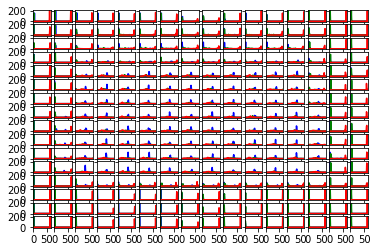

In [112]:
plt.figure()
img_n = 0
histr = all_hist[dict_class[0],img_n] # hist of first image in class 0 
print(histr.shape)

fig, axes = plt.subplots(grid,grid,sharex=True, sharey=True)
color = ('b','g','r')
for i in range(grid):
    for j in range(grid):
        #print(i*grid+j)
        for c, col in enumerate(color):

            axes[i,j].plot(histr[c][i*grid+j], color = col)
            axes[i,j].set_xlim([0, bin_num])
        

        
plt.savefig("class0_img{}_color_hist_bin{}_gridsize{}.jpg".format(img_n,bin_num,grid),dpi=150)

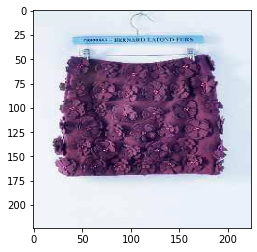

In [122]:
plt.imshow(imgs[0][img_n])
plt.savefig("class0_img[0]")

# Co-occurence Matrix 

In [146]:
def gray_level(pattern,pixel_range=16):
    return np.floor(pattern/pixel_range)

def co_occurence(input_pattern,pixel_range=16):
    co_m_01 = np.zeros((pixel_range,pixel_range))
    co_m_10 = np.zeros((pixel_range,pixel_range))
    co_m_11 = np.zeros((pixel_range,pixel_range))
    input_pattern = np.int_(gray_level(input_pattern,pixel_range))
    # d = (0,1)
    leng = input_pattern.shape[0]
    for i in range(leng):
        for j in range(leng-1):
            co_m_01[input_pattern[i,j],input_pattern[i,j+1]] +=1
    # d = (1,0)
    for i in range(leng):
        for j in range(leng-1):
            co_m_10[input_pattern[j,i],input_pattern[j+1,i]] +=1
    for i in range(leng-1):
        for j in range(leng-1):
            co_m_11[input_pattern[i,j],input_pattern[i+1,j+1]] +=1
    return np.array([co_m_01, co_m_10, co_m_11])
#co_occurence(np.array([[16,25],[26,244]]))

In [148]:
all_occu = {}
bin_num = 64
grid = 4
image_size = 224
for c , class_imgs in enumerate(imgs):
    for n, img in enumerate(class_imgs):
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_hist = []
        
        grid_h = int(image_size/grid)
        grid_w = int(image_size/grid)
        hist_arr = []
        for i in range(grid):
            for j in range(grid):
                gray_hist += [co_occurence(img[i*grid_h:i*grid_h+grid_h,j*grid_w:j*grid_w+grid_w])]

        all_occu[dict_class[c],n] = np.array(np.array(gray_hist))
all_occu[dict_class[0],0].shape

(64, 3, 16, 16)

In [149]:
#write_csv(method="Co_ocurence")

# Edge Histogram Descriptor

In [93]:
verti = np.array([[1,-1],[1,-1]])
hori = np.array([[1,1],[-1,-1]])
deg45 = np.array([[2**0.5,0],[0,-(2**0.5)]])
deg135 = np.array([[0,2**0.5],[-(2**0.5),0]])
non_dir = np.array([[2,-2],[-2,2]])


def EHD(input_pattern,block_size = 4,T_edge=0):
    # 56*56 pattern
    # 0 : "vertical", 1 : horizontal , 2 : 45 degree, 3: 135 degree , 4 : non-direction 
    
    #split into 14*14 image block when block size = 4
    
    l = input_pattern.shape[0]
    # split each block into 4 sub block
    block_size /= 2
    block_size = int(block_size)
    block_l = int(l / block_size)
    new_pattern = np.zeros((block_l, block_l))
    for i in range(block_l):
        for j in range(block_l):
             
            new_pattern[i][j] = np.average(input_pattern[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size])
    
    hist = [0,0,0,0,0]
    """block_l /=2
    block_l = int(block_l)
    verti_p = np.zeros((block_l, block_l))
    hori_p =np.zeros((block_l, block_l))
    deg45_p =np.zeros((block_l, block_l))
    deg135_p =np.zeros((block_l, block_l))
    non_dir_p = np.zeros((block_l, block_l))"""
    """for i in range(0,block_l):
        for j in range(0,block_l):
            verti_p[i,j] = np.sum(np.multiply(new_pattern[2*i:2*i+2,2*j:2*j+2],verti))
            hori_p[i,j] = np.sum(np.multiply(new_pattern[2*i:2*i+2,2*j:2*j+2],hori))
            deg45_p[i,j] = np.sum(np.multiply(new_pattern[2*i:2*i+2,2*j:2*j+2],deg45))
            deg135_p[i,j] = np.sum(np.multiply(new_pattern[2*i:2*i+2,2*j:2*j+2],deg135))
            non_dir_p[i,j] = np.sum(np.multiply(new_pattern[2*i:2*i+2,2*j:2*j+2],non_dir))"""
    #print(new_pattern.shape)
            
    verti_p = cv2.filter2D(new_pattern,ddepth=-1, kernel=verti)
    hori_p = cv2.filter2D(new_pattern,ddepth=-1, kernel=hori)
    deg45_p = cv2.filter2D(new_pattern,ddepth=-1, kernel=deg45)
    deg135_p = cv2.filter2D(new_pattern,ddepth=-1, kernel=deg135)
    non_dir_p = cv2.filter2D(new_pattern,ddepth=-1, kernel=non_dir)
    #print(verti_p.shape)
    verti_p = verti_p[1::2,1::2]
    #print(verti_p.shape)
    hori_p = hori_p[1::2,1::2]
    deg45_p = deg45_p[1::2,1::2]
    deg135_p = deg135_p[1::2,1::2]
    non_dir_p = non_dir_p[1::2,1::2]
    leng = verti_p.shape[0]
    for i in range(leng):
        for j in range(leng):
            cmp_a = np.array([verti_p[i,j],hori_p[i,j],deg45_p[i,j],deg135_p[i,j],non_dir_p[i,j]])
            index = np.argmax( cmp_a )
            if cmp_a[index] > T_edge:
                hist[index]+=1
    return hist

In [95]:
threshold = 40
all_edge = {}
#bin_num = 64
grid =4
image_size = 224
for c , class_imgs in enumerate(imgs):
    for n, img in enumerate(class_imgs):
        #print(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_hist = []
        
        grid_h = int(image_size/grid)
        grid_w = int(image_size/grid)
        hist_arr = []
        for i in range(grid):
            for j in range(grid):
                gray_hist += [EHD(img[i*grid_h:i*grid_h+grid_h,j*grid_w:j*grid_w+grid_w],T_edge=threshold)]

        all_edge[dict_class[c],n] = np.array(gray_hist)
all_edge[dict_class[0],0].shape

(16, 5)

# EHD Score, Ranking, Get AP 

In [96]:
#top = 19
AP = score_ranking_ap(all_edge,L1,dim=2)
AP

('skirt', 0)
[2, 41, 225, 338, 343, 369, 427, 432, 446, 458, 475, 483, 533, 548, 550, 573, 577, 592, 594]
('skirt', 1)
[69, 101, 170, 263, 271, 278, 291, 316, 417, 430, 489, 518, 537, 549, 554, 565, 567, 588, 594]
('skirt', 2)
[210, 217, 265, 360, 374, 399, 470, 488, 494, 496, 508, 509, 522, 555, 569, 585, 590, 593, 594]
('skirt', 3)
[7, 38, 54, 93, 139, 162, 164, 174, 309, 330, 354, 465, 490, 494, 515, 551, 554, 583, 589]
('skirt', 4)
[10, 12, 30, 68, 190, 194, 214, 227, 313, 378, 415, 423, 447, 450, 520, 537, 585, 593, 595]
('skirt', 5)
[35, 97, 159, 179, 251, 263, 345, 366, 370, 435, 458, 489, 490, 523, 531, 575, 583, 593, 594]
('skirt', 6)
[39, 212, 242, 264, 324, 355, 432, 456, 492, 522, 523, 530, 535, 537, 571, 586, 588, 591, 593]
('skirt', 7)
[1, 3, 4, 6, 12, 35, 42, 58, 86, 157, 162, 164, 174, 178, 185, 200, 244, 262, 563]
('skirt', 8)
[25, 28, 64, 72, 193, 200, 208, 273, 284, 365, 376, 379, 437, 474, 490, 528, 562, 593, 595]
('skirt', 9)
[1, 4, 7, 8, 9, 45, 68, 80, 105, 114, 1

[73, 100, 129, 211, 215, 227, 233, 276, 292, 363, 370, 420, 454, 500, 509, 515, 519, 537, 557]
('drum', 4)
[47, 53, 90, 97, 104, 143, 151, 271, 334, 392, 435, 455, 479, 509, 512, 520, 536, 553, 554]
('drum', 5)
[2, 6, 35, 48, 193, 254, 257, 278, 413, 417, 454, 480, 493, 503, 521, 528, 533, 543, 551]
('drum', 6)
[2, 24, 55, 260, 261, 288, 343, 344, 397, 440, 449, 451, 466, 473, 474, 475, 527, 537, 561]
('drum', 7)
[1, 5, 6, 17, 51, 92, 143, 156, 246, 264, 328, 332, 402, 458, 498, 499, 520, 544, 555]
('drum', 8)
[1, 2, 5, 78, 109, 111, 154, 173, 291, 317, 329, 332, 397, 446, 479, 505, 537, 561, 586]
('drum', 9)
[80, 160, 176, 185, 213, 219, 240, 293, 329, 357, 360, 361, 362, 425, 506, 526, 529, 531, 547]
('drum', 10)
[4, 6, 7, 15, 32, 34, 46, 49, 61, 169, 174, 179, 189, 209, 315, 322, 467, 469, 519]
('drum', 11)
[7, 8, 12, 13, 14, 15, 43, 68, 72, 75, 125, 137, 200, 206, 256, 319, 340, 369, 376]
('drum', 12)
[1, 6, 44, 56, 64, 86, 90, 100, 112, 199, 204, 213, 295, 316, 323, 325, 369, 428,

[3, 38, 40, 46, 59, 62, 72, 103, 107, 113, 120, 126, 167, 172, 175, 179, 203, 363, 414]
('korean_snack', 9)
[1, 2, 3, 4, 7, 8, 9, 11, 13, 17, 36, 44, 47, 69, 94, 116, 123, 159, 175]
('korean_snack', 10)
[42, 111, 203, 214, 286, 295, 300, 310, 374, 385, 465, 497, 499, 527, 548, 549, 551, 556, 569]
('korean_snack', 11)
[1, 3, 4, 5, 10, 12, 13, 17, 32, 33, 37, 39, 52, 60, 62, 65, 77, 105, 181]
('korean_snack', 12)
[1, 2, 4, 5, 7, 20, 26, 39, 47, 49, 115, 158, 202, 233, 322, 396, 415, 425, 501]
('korean_snack', 13)
[59, 123, 126, 147, 180, 236, 244, 273, 296, 393, 427, 449, 459, 478, 495, 515, 528, 536, 559]
('korean_snack', 14)
[2, 3, 6, 8, 9, 14, 16, 19, 25, 26, 45, 71, 105, 119, 137, 180, 237, 263, 342]
('korean_snack', 15)
[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 18, 21, 24, 51, 52, 54, 224]
('korean_snack', 16)
[2, 3, 4, 5, 6, 7, 16, 19, 20, 21, 27, 30, 53, 55, 80, 85, 105, 123, 127]
('korean_snack', 17)
[1, 2, 5, 12, 16, 17, 20, 42, 50, 60, 63, 68, 90, 99, 100, 104, 121, 176, 216]
(

[2, 3, 34, 35, 38, 63, 81, 84, 92, 132, 179, 209, 210, 230, 392, 413, 467, 497, 519]
('cartoon_purse', 7)
[2, 24, 26, 29, 30, 31, 32, 55, 60, 66, 108, 115, 136, 158, 176, 185, 443, 444, 557]
('cartoon_purse', 8)
[1, 9, 10, 13, 21, 23, 24, 27, 28, 30, 36, 46, 47, 56, 207, 219, 312, 351, 543]
('cartoon_purse', 9)
[1, 8, 21, 27, 32, 33, 45, 63, 81, 83, 102, 109, 145, 148, 162, 170, 249, 413, 417]
('cartoon_purse', 10)
[3, 4, 7, 16, 24, 25, 26, 28, 69, 95, 109, 118, 135, 206, 248, 301, 329, 402, 473]
('cartoon_purse', 11)
[1, 3, 8, 19, 29, 37, 96, 97, 109, 122, 157, 177, 277, 286, 325, 356, 357, 409, 410]
('cartoon_purse', 12)
[2, 3, 16, 17, 34, 44, 48, 81, 100, 130, 141, 166, 225, 277, 289, 343, 427, 459, 491]
('cartoon_purse', 13)
[4, 7, 19, 20, 26, 44, 71, 83, 88, 134, 155, 160, 201, 204, 213, 289, 397, 486, 528]
('cartoon_purse', 14)
[1, 3, 4, 8, 9, 11, 12, 14, 20, 30, 55, 144, 152, 170, 176, 276, 284, 296, 443]
('cartoon_purse', 15)
[3, 18, 21, 27, 36, 49, 50, 62, 81, 86, 93, 98, 103,

[1, 2, 3, 6, 13, 40, 59, 105, 126, 218, 226, 234, 260, 325, 342, 396, 402, 417, 449]
('minnie_dress', 8)
[1, 2, 3, 4, 14, 22, 25, 52, 83, 170, 184, 197, 238, 314, 367, 387, 401, 421, 438]
('minnie_dress', 9)
[1, 3, 9, 10, 13, 23, 36, 54, 59, 129, 158, 159, 181, 326, 361, 388, 392, 409, 421]
('minnie_dress', 10)
[17, 19, 37, 69, 87, 128, 138, 214, 217, 249, 250, 348, 367, 384, 397, 445, 462, 471, 477]
('minnie_dress', 11)
[3, 17, 44, 47, 48, 51, 59, 72, 105, 152, 211, 381, 388, 390, 417, 429, 433, 444, 447]
('minnie_dress', 12)
[9, 11, 16, 40, 49, 139, 222, 224, 233, 248, 251, 258, 283, 296, 317, 349, 433, 439, 490]
('minnie_dress', 13)
[3, 34, 111, 141, 220, 226, 246, 247, 248, 295, 307, 314, 315, 316, 350, 354, 384, 389, 398]
('minnie_dress', 14)
[1, 2, 3, 5, 13, 26, 34, 53, 91, 96, 120, 132, 141, 209, 240, 253, 290, 305, 397]
('minnie_dress', 15)
[12, 13, 16, 51, 62, 90, 108, 117, 121, 186, 238, 240, 281, 302, 308, 321, 347, 352, 396]
('minnie_dress', 16)
[1, 2, 6, 10, 21, 54, 79, 12

[1, 2, 3, 4, 7, 10, 20, 41, 82, 109, 151, 215, 346, 373, 399, 410, 441, 564, 576]
('leather_purse', 4)
[1, 2, 3, 4, 5, 6, 7, 17, 33, 50, 124, 176, 272, 337, 361, 387, 495, 560, 572]
('leather_purse', 5)
[1, 2, 3, 4, 5, 8, 15, 21, 72, 94, 196, 205, 326, 376, 389, 416, 461, 563, 578]
('leather_purse', 6)
[1, 2, 3, 4, 5, 6, 14, 18, 23, 54, 128, 152, 333, 347, 358, 390, 454, 556, 574]
('leather_purse', 7)
[1, 2, 3, 17, 23, 45, 53, 54, 160, 197, 237, 249, 322, 350, 376, 416, 463, 560, 572]
('leather_purse', 8)
[3, 24, 36, 37, 43, 57, 67, 72, 121, 143, 157, 236, 327, 354, 363, 465, 541, 575, 586]
('leather_purse', 9)
[7, 9, 14, 15, 23, 24, 30, 34, 46, 78, 83, 87, 233, 275, 436, 455, 463, 471, 515]
('leather_purse', 10)
[26, 30, 42, 56, 73, 95, 112, 140, 147, 179, 230, 270, 294, 323, 341, 434, 441, 514, 540]
('leather_purse', 11)
[1, 2, 3, 4, 5, 7, 10, 11, 19, 21, 85, 93, 263, 322, 323, 380, 521, 564, 577]
('leather_purse', 12)
[1, 63, 115, 152, 157, 188, 312, 336, 347, 355, 395, 404, 412, 44

[22, 43, 103, 109, 110, 126, 180, 190, 204, 210, 241, 284, 304, 335, 358, 387, 392, 398, 428]
('overalls', 4)
[1, 2, 3, 4, 37, 40, 41, 62, 64, 84, 173, 178, 183, 211, 244, 309, 312, 336, 344]
('overalls', 5)
[1, 7, 8, 9, 12, 15, 31, 34, 46, 63, 87, 123, 143, 152, 208, 279, 280, 324, 385]
('overalls', 6)
[7, 11, 14, 15, 16, 17, 18, 21, 43, 59, 131, 138, 149, 184, 185, 266, 297, 304, 383]
('overalls', 7)
[1, 2, 3, 5, 32, 34, 35, 43, 54, 66, 163, 185, 200, 202, 266, 294, 317, 337, 343]
('overalls', 8)
[5, 15, 16, 134, 158, 162, 163, 188, 194, 195, 210, 241, 265, 266, 296, 301, 344, 345, 444]
('overalls', 9)
[4, 6, 16, 29, 35, 38, 59, 75, 80, 88, 94, 95, 109, 121, 131, 188, 211, 299, 316]
('overalls', 10)
[10, 17, 18, 19, 36, 85, 96, 119, 120, 129, 213, 218, 249, 265, 271, 307, 338, 349, 353]
('overalls', 11)
[1, 2, 3, 5, 35, 37, 42, 51, 77, 89, 180, 189, 200, 216, 251, 302, 324, 346, 366]
('overalls', 12)
[1, 2, 5, 9, 13, 14, 17, 19, 21, 27, 30, 35, 45, 70, 113, 140, 166, 307, 337]
('over

{('skirt', 0): 0.04877378293384169,
 ('skirt', 1): 0.02340735509510975,
 ('skirt', 2): 0.019721538015735837,
 ('skirt', 3): 0.04099400843595894,
 ('skirt', 4): 0.04583958743216697,
 ('skirt', 5): 0.02484370269003663,
 ('skirt', 6): 0.021325275166397956,
 ('skirt', 7): 0.2511584884361866,
 ('skirt', 8): 0.03502442981512715,
 ('skirt', 9): 0.2212562374866508,
 ('skirt', 10): 0.04883797231605643,
 ('skirt', 11): 0.03468695650540874,
 ('skirt', 12): 0.23797823954794103,
 ('skirt', 13): 0.038144500149474805,
 ('skirt', 14): 0.05561716541845598,
 ('skirt', 15): 0.03680759105396545,
 ('skirt', 16): 0.11779051648982569,
 ('skirt', 17): 0.21742343200945052,
 ('skirt', 18): 0.048756338941359875,
 ('skirt', 19): 0.08777680724053569,
 ('ice_cream', 0): 0.057776013382151215,
 ('ice_cream', 1): 0.1282954718859596,
 ('ice_cream', 2): 0.12314525087585293,
 ('ice_cream', 3): 0.08470133355027615,
 ('ice_cream', 4): 0.07417203245732659,
 ('ice_cream', 5): 0.04724171932787891,
 ('ice_cream', 6): 0.0690139

In [97]:
class_map_arr , all_map = m_ap(AP)
compare_map = sorted(class_map_arr.items(), key=lambda kv: kv[1])
print("Worst 2 Categories")
print(compare_map[0],compare_map[1])
print("Best 2 Categories")
print(compare_map[-1],compare_map[-2])

print(all_map)

Worst 2 Categories
('hand_cream', 0.06236955340338922) ('ice_cream', 0.07297464066147957)
Best 2 Categories
('goggles', 0.5777774456632335) ('gge_snack', 0.39368976005853473)
0.19187001440242232


In [98]:
#print(AP)
#threshold = 0
write_csv(method="EHD",bin_num=5, grid=grid)

(16, 5)
[2 4 2 1 2]
[ 2 39  6  1  2]
[ 6 32  6  2  3]
[2 5 0 3 3]
[12  3  8  4 11]
[12  6  4 11 23]
[10  5  6  7 31]
[ 1  0  2 16 12]
[19  7  3  5 19]
[19 10  4  9 27]
[13  7  4 13 29]
[ 5  1  3 16 17]
[1 0 0 0 1]
[0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0]


<Figure size 432x288 with 0 Axes>

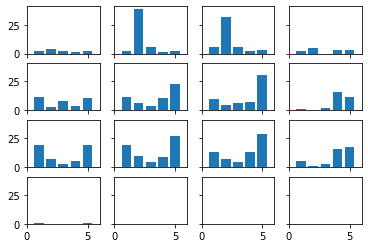

In [99]:
plt.figure()
img_n = 0
histr = all_edge[dict_class[0],img_n] # hist of first image in class 0 
print(histr.shape)

fig, axes = plt.subplots(grid,grid,sharex=True, sharey=True)
color = ('b','g','r')
for i in range(grid):
    for j in range(grid):
        #print(i*grid+j)
        #print(histr[i*grid+j])
        axes[i,j].bar([1,2,3,4,5],histr[i*grid+j])
        axes[i,j].set_xlim([0, 6])
        

        
#plt.savefig("class0_img{}_EHD_gridsize{}_threshold{}.jpg".format(img_n,grid,threshold),dpi=150)

# Local Feature

Threshold: 50
nonmaxSuppression:True
neighborhood: 2
Total Keypoints with nonmaxSuppression: 218


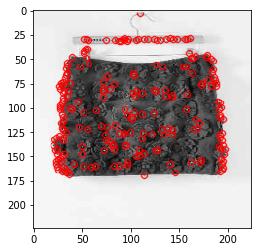

In [39]:
# sift feature and fast detection


print( "Threshold: {}".format(fast.getThreshold()) )
print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
print( "neighborhood: {}".format(fast.getType()) )
print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp)) )
plt.imshow(img2)

In [79]:
all_sift = {}
for c , class_imgs in enumerate(imgs):
    for n, img in enumerate(class_imgs):
        
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift_hist = []
        ####get feature####
        detector = cv2.FastFeatureDetector_create()
        kps = detector.detect(img)
        
        #sift = cv2.xfeatures2d.SIFT_create()
        
        sift = cv2.xfeatures2d.SIFT_create()
    
        
        #fast = cv2.FastFeatureDetector_create(50)
        #print(class_imgs[0])
        #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ####get descriptor####
        kp, feature= sift.compute(img,kps)
        #gray = cv2.drawKeypoints(gray, kp, None, color=(255,0,0))
        #print(kp)
        hist_arr = []
        #print(feature.shape)
        
        all_sift[dict_class[c],n] = (kp,feature)
        #all_sift[dict_class[c],n] = feature

m distance :133.973876953125, n distance: 168.25872802734375
m distance :208.830078125, n distance: 269.0520324707031
m distance :171.55465698242188, n distance: 202.10145568847656
m distance :139.24798583984375, n distance: 254.79403686523438
m distance :145.85609436035156, n distance: 202.65240478515625
m distance :170.2586212158203, n distance: 225.70777893066406
m distance :195.05126953125, n distance: 295.0542297363281
m distance :159.7498016357422, n distance: 200.53677368164062
m distance :213.51345825195312, n distance: 258.4646911621094
m distance :196.83749389648438, n distance: 235.72653198242188
m distance :147.2718505859375, n distance: 184.92971801757812
m distance :203.18218994140625, n distance: 255.0980224609375
m distance :218.40328979492188, n distance: 257.60821533203125
m distance :188.8306121826172, n distance: 231.65492248535156
m distance :182.44451904296875, n distance: 217.08753967285156
m distance :195.892822265625, n distance: 241.57400512695312
m distance :

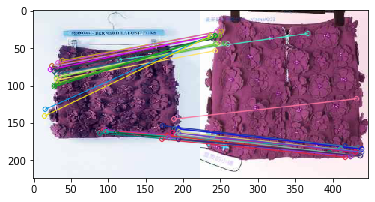

In [85]:
# brute force matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(all_sift[dict_class[0],0][1],all_sift[dict_class[0],5][1], k=2)
# Apply ratio 
ratio = 0.85
good = []
for m,n in matches:
    
    #print("m distance :{}, n distance: {}".format(m.distance, n.distance))
    if m.distance < ratio*n.distance:
        print("m distance :{}, n distance: {}".format(m.distance, n.distance))
        good.append([m])
img3 = cv2.drawMatchesKnn(imgs[0][0],all_sift[dict_class[0],0][0],imgs[0][5],all_sift[dict_class[0],5][0],good,None,flags=2)
plt.imshow(img3)

# Match Similarity

In [81]:

def match(hist1, hist2,dim=0.75):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(hist1[1],hist2[1], k=2)
    ratio = dim
    good = []
    for m,n in matches:

        #print("m distance :{}, n distance: {}".format(m.distance, n.distance))
        if m.distance < ratio*n.distance:
            #print("m distance :{}, n distance: {}".format(m.distance, n.distance))
            good.append([m])
    return len(good)


In [87]:
AP = score_ranking_ap(all_sift,match,dim=0.85,reverse=True)
AP

('skirt', 0)
[23, 49, 66, 83, 86, 178, 197, 210, 211, 263, 292, 318, 387, 426, 483, 484, 485, 486, 487]
('skirt', 1)
[59, 70, 117, 146, 177, 178, 287, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392]
('skirt', 2)
[18, 22, 122, 123, 136, 194, 207, 234, 247, 264, 287, 341, 366, 396, 397, 450, 451, 452, 453]
('skirt', 3)
[1, 2, 17, 25, 31, 40, 178, 179, 268, 269, 270, 271, 343, 344, 345, 346, 347, 348, 349]
('skirt', 4)
[1, 2, 66, 86, 107, 108, 127, 151, 236, 291, 292, 385, 386, 387, 435, 436, 437, 495, 496]
('skirt', 5)
[57, 79, 86, 91, 152, 168, 176, 237, 259, 260, 261, 292, 348, 349, 350, 351, 384, 488, 489]
('skirt', 6)
[50, 117, 149, 196, 197, 266, 267, 268, 269, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]
('skirt', 7)
[1, 141, 199, 200, 201, 202, 203, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305]
('skirt', 8)
[16, 191, 192, 241, 242, 243, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333]
('skirt', 9)
[1, 21, 127, 163, 164, 165, 206, 207,

[5, 30, 31, 34, 47, 56, 64, 65, 79, 88, 89, 90, 92, 119, 157, 237, 238, 239, 302]
('goggles', 4)
[5, 9, 10, 17, 25, 26, 27, 28, 44, 45, 104, 105, 106, 262, 263, 264, 265, 266, 267]
('goggles', 5)
[1, 2, 8, 15, 16, 17, 18, 19, 23, 41, 42, 43, 44, 65, 66, 88, 106, 132, 363]
('goggles', 6)
[3, 4, 7, 11, 13, 15, 16, 17, 21, 22, 26, 30, 44, 57, 58, 79, 157, 158, 159]
('goggles', 7)
[1, 3, 7, 8, 12, 15, 19, 23, 24, 32, 39, 40, 44, 45, 64, 89, 104, 105, 189]
('goggles', 8)
[13, 36, 37, 38, 58, 59, 60, 91, 92, 93, 94, 131, 132, 174, 175, 176, 266, 267, 413]
('goggles', 9)
[1, 2, 3, 5, 8, 12, 13, 14, 15, 21, 35, 36, 60, 95, 96, 115, 116, 117, 318]
('goggles', 10)
[15, 20, 25, 54, 55, 56, 85, 86, 121, 122, 123, 124, 125, 186, 187, 188, 323, 324, 325]
('goggles', 11)
[1, 23, 40, 41, 51, 59, 70, 71, 104, 105, 106, 107, 108, 133, 150, 176, 177, 178, 219]
('goggles', 12)
[1, 3, 7, 9, 10, 14, 25, 39, 48, 53, 54, 62, 68, 84, 112, 153, 154, 186, 233]
('goggles', 13)
[1, 2, 3, 8, 10, 12, 22, 23, 24, 29,

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 44, 50, 51, 79, 90, 194, 257, 345, 490]
('garment', 8)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 21, 43, 62, 74, 87, 257, 352, 353]
('garment', 9)
[1, 4, 35, 46, 57, 99, 100, 167, 248, 249, 250, 251, 252, 403, 404, 405, 406, 407, 408]
('garment', 10)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 24, 57, 64, 85, 86, 159, 202, 264, 357]
('garment', 11)
[1, 2, 3, 4, 5, 6, 7, 9, 10, 15, 32, 53, 63, 81, 118, 148, 177, 328, 457]
('garment', 12)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 27, 38, 85, 109, 110, 178, 314, 315]
('garment', 13)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 49, 60, 83, 84, 85, 94, 154, 342, 477]
('garment', 14)
[7, 81, 82, 83, 84, 122, 123, 124, 125, 126, 170, 171, 172, 239, 240, 241, 242, 243, 424]
('garment', 15)
[1, 4, 6, 16, 20, 31, 32, 35, 45, 59, 79, 139, 140, 141, 273, 274, 275, 276, 433]
('garment', 16)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 46, 47, 60, 61, 62, 90, 196, 269, 422]
('garment', 17)
[6, 7, 8, 9, 10, 12, 14, 35, 44, 45, 46, 47, 58, 64, 65, 88, 89, 227, 228]
('g

[2, 8, 16, 36, 40, 41, 42, 61, 94, 115, 116, 117, 118, 139, 224, 225, 282, 356, 532]
('children_dress', 9)
[2, 7, 10, 11, 13, 14, 17, 18, 32, 41, 42, 55, 56, 57, 70, 71, 105, 124, 125]
('children_dress', 10)
[1, 2, 3, 4, 5, 6, 7, 8, 12, 16, 26, 39, 49, 50, 70, 77, 164, 296, 360]
('children_dress', 11)
[3, 10, 11, 14, 15, 21, 25, 28, 30, 49, 50, 51, 52, 72, 90, 102, 103, 209, 265]
('children_dress', 12)
[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 15, 27, 28, 31, 39, 40, 191, 192, 388]
('children_dress', 13)
[2, 21, 34, 45, 62, 98, 110, 125, 145, 199, 200, 232, 280, 281, 353, 354, 355, 356, 535]
('children_dress', 14)
[1, 2, 3, 4, 5, 6, 7, 9, 10, 17, 19, 36, 44, 50, 61, 131, 161, 267, 345]
('children_dress', 15)
[1, 11, 24, 25, 26, 47, 48, 67, 92, 93, 150, 151, 152, 223, 224, 421, 422, 423, 424]
('children_dress', 16)
[3, 7, 11, 15, 21, 24, 27, 30, 31, 39, 40, 47, 55, 63, 84, 95, 96, 127, 423]
('children_dress', 17)
[1, 5, 7, 8, 9, 30, 39, 51, 52, 62, 63, 94, 95, 118, 177, 178, 223, 286, 287]
('chi

[1, 2, 5, 7, 19, 20, 22, 52, 70, 138, 139, 159, 188, 189, 272, 273, 375, 438, 439]
('women_clothes', 9)
[2, 11, 50, 62, 74, 118, 153, 197, 198, 251, 252, 253, 321, 322, 323, 491, 492, 493, 494]
('women_clothes', 10)
[8, 39, 44, 52, 104, 127, 155, 156, 178, 179, 180, 181, 213, 281, 282, 358, 359, 513, 514]
('women_clothes', 11)
[1, 2, 5, 6, 11, 12, 18, 20, 24, 29, 71, 94, 107, 108, 130, 131, 161, 213, 214]
('women_clothes', 12)
[1, 2, 3, 11, 17, 18, 30, 36, 55, 56, 91, 174, 244, 245, 246, 247, 248, 249, 496]
('women_clothes', 13)
[1, 2, 14, 30, 38, 43, 49, 54, 100, 101, 123, 136, 137, 147, 148, 149, 229, 258, 370]
('women_clothes', 14)
[1, 2, 3, 4, 5, 16, 17, 24, 27, 37, 92, 93, 94, 95, 325, 326, 327, 501, 502]
('women_clothes', 15)
[16, 23, 36, 103, 133, 134, 160, 161, 193, 217, 254, 255, 394, 395, 522, 523, 524, 525, 526]
('women_clothes', 16)
[1, 15, 33, 46, 55, 86, 87, 162, 251, 252, 253, 254, 255, 256, 257, 258, 467, 468, 469]
('women_clothes', 17)
[1, 2, 8, 29, 44, 46, 76, 90, 91,

[4, 12, 26, 43, 44, 50, 61, 70, 116, 117, 130, 131, 286, 333, 411, 552, 553, 554]
('bicycle', 8)
[1, 2, 5, 7, 10, 19, 22, 29, 31, 33, 45, 95, 103, 111, 268, 354, 411, 550]
('bicycle', 9)
[1, 2, 4, 5, 7, 8, 12, 23, 63, 64, 66, 67, 168, 169, 281, 282, 359, 549]
('bicycle', 10)
[2, 3, 7, 9, 11, 12, 13, 38, 49, 51, 52, 142, 143, 187, 188, 383, 550, 551]
('bicycle', 11)
[2, 10, 12, 19, 23, 44, 54, 62, 121, 122, 149, 183, 184, 244, 337, 338, 528, 529]
('bicycle', 12)
[1, 2, 5, 10, 12, 20, 33, 42, 47, 49, 65, 124, 144, 254, 255, 367, 541, 542]
('bicycle', 13)
[1, 12, 16, 19, 22, 32, 38, 43, 66, 78, 88, 118, 119, 139, 171, 207, 550, 551]
('bicycle', 14)
[1, 2, 3, 4, 6, 22, 24, 25, 37, 45, 86, 89, 97, 98, 193, 336, 405, 406]
('bicycle', 15)
[13, 16, 24, 37, 60, 70, 80, 106, 152, 153, 194, 250, 324, 325, 542, 543, 544, 545]
('bicycle', 16)
[2, 5, 21, 22, 29, 30, 40, 56, 70, 80, 136, 167, 215, 216, 217, 261, 262, 548]
('bicycle', 17)
[40, 75, 76, 96, 132, 260, 331, 332, 333, 334, 335, 530, 531, 5

[1, 3, 4, 6, 7, 10, 12, 15, 19, 23, 64, 65, 79, 155, 297, 298, 378, 571, 572]
('leather_purse', 10)
[14, 64, 82, 231, 232, 233, 234, 235, 236, 237, 238, 534, 535, 536, 537, 538, 539, 540, 541]
('leather_purse', 11)
[1, 2, 5, 9, 10, 12, 31, 49, 55, 100, 101, 126, 161, 258, 259, 260, 378, 379, 574]
('leather_purse', 12)
[1, 26, 30, 61, 116, 117, 231, 296, 297, 298, 386, 387, 388, 560, 561, 562, 563, 564, 565]
('leather_purse', 13)
[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 23, 24, 43, 140, 163, 237, 403, 578, 579]
('leather_purse', 14)
[131, 132, 188, 292, 293, 294, 295, 296, 297, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550]
('leather_purse', 15)
[1, 19, 29, 45, 93, 151, 177, 258, 322, 323, 415, 416, 417, 418, 419, 571, 572, 573, 574]
('leather_purse', 16)
[2, 3, 4, 5, 7, 9, 10, 57, 62, 65, 66, 104, 105, 106, 124, 263, 321, 378, 585]
('leather_purse', 17)
[30, 40, 52, 56, 84, 105, 138, 170, 171, 172, 206, 286, 287, 288, 564, 565, 566, 567, 568]
('leather_purse', 18)
[6, 63, 70, 71, 72, 73, 96

[1, 3, 18, 19, 27, 31, 32, 51, 74, 75, 91, 232, 233, 234, 235, 236, 320, 590, 591]
('orange', 13)
[1, 2, 4, 5, 7, 9, 10, 13, 17, 35, 59, 114, 145, 180, 238, 239, 334, 590, 591]
('orange', 14)
[4, 26, 33, 44, 66, 67, 126, 127, 128, 129, 130, 131, 236, 237, 238, 584, 585, 586, 587]
('orange', 15)
[2, 26, 31, 61, 62, 77, 91, 92, 108, 109, 110, 140, 190, 191, 259, 348, 349, 588, 589]
('orange', 16)
[33, 62, 63, 73, 107, 127, 128, 129, 130, 250, 251, 252, 582, 583, 584, 585, 586, 587, 588]
('orange', 17)
[2, 3, 13, 22, 40, 41, 56, 81, 184, 185, 186, 187, 577, 578, 579, 580, 581, 582, 583]
('orange', 18)
[29, 38, 39, 46, 62, 71, 86, 87, 104, 105, 123, 124, 164, 285, 352, 353, 592, 593, 594]
('orange', 19)
[3, 4, 8, 21, 26, 57, 65, 66, 86, 109, 185, 186, 261, 262, 350, 351, 591, 592, 593]
('overalls', 0)
[1, 2, 4, 5, 7, 8, 12, 32, 56, 57, 84, 192, 193, 305, 306, 381, 596, 597, 598]
('overalls', 1)
[16, 23, 24, 29, 33, 46, 56, 57, 91, 138, 226, 304, 305, 306, 307, 595, 596, 597, 598]
('overall

{('skirt', 0): 0.03900914479503062,
 ('skirt', 1): 0.031743567197604114,
 ('skirt', 2): 0.03951460692486393,
 ('skirt', 3): 0.16900178015067507,
 ('skirt', 4): 0.14201552764241193,
 ('skirt', 5): 0.037169061591332424,
 ('skirt', 6): 0.03194422709024625,
 ('skirt', 7): 0.0882999961503312,
 ('skirt', 8): 0.03503847481131994,
 ('skirt', 9): 0.09629202658864228,
 ('skirt', 10): 0.09095165533795016,
 ('skirt', 11): 0.08544598494135422,
 ('skirt', 12): 0.10373707798733887,
 ('skirt', 13): 0.03446009911254543,
 ('skirt', 14): 0.032071623289362014,
 ('skirt', 15): 0.03309108825112321,
 ('skirt', 16): 0.24321960996631792,
 ('skirt', 17): 0.12302041072056395,
 ('skirt', 18): 0.0895227553002465,
 ('skirt', 19): 0.08285370619009651,
 ('ice_cream', 0): 0.05454730609818634,
 ('ice_cream', 1): 0.035865171327168516,
 ('ice_cream', 2): 0.038708786499515604,
 ('ice_cream', 3): 0.053522601383923826,
 ('ice_cream', 4): 0.029216983551375357,
 ('ice_cream', 5): 0.036507872008944446,
 ('ice_cream', 6): 0.057

In [90]:
class_map_arr , all_map = m_ap(AP)
compare_map = sorted(class_map_arr.items(), key=lambda kv: kv[1])
print("Worst 2 Categories")
print(compare_map[0],compare_map[1])
print("Best 2 Categories")
print(compare_map[-1],compare_map[-2])

print(all_map)

Worst 2 Categories
('drum', 0.04374315606757081) ('ice_cream', 0.0443901302060061)
Best 2 Categories
('gge_snack', 0.5771230619498409) ('aloe_vera_gel', 0.45865386591156504)
0.21899089008451814


In [91]:
write_csv(method="SIFT",bin_num=0, grid=0)

# Fusion

# Get AP for each class from different method

### use these AP to get the weight for computing the fusion score 

In [141]:
AP_color = {}
with open("ColorHistogram_APperImg_bin64_gridsize16.csv", mode='r') as infile:
    reader = csv.reader(infile)
    AP_color =  {rows[0]:float(rows[1]) for rows in reader}
AP_edge ={}
with open('EHD_APperImg_bin5_gridsize4.csv', mode='r') as infile:
    reader = csv.reader(infile)
    AP_edge =  {rows[0]:float(rows[1]) for rows in reader}
AP_sift = {} 
with open('SIFT_APperImg_ratio0.85.csv', mode='r') as infile:
    reader = csv.reader(infile)
    AP_sift = {rows[0]: float(rows[1]) for rows in reader}



In [142]:
AP = {}
for c, hist in all_hist.items():
    target = c[0]
    score_color ={}
    score_edge ={}
    score_sift ={}
    score = {}
    right_index = []
    score ={}
    recall = {}
    precision = {}
    if hist is None : 
        continue
    print(c)
    max_color = 0
    max_edge = 0
    max_sift = 0
    for c_t, hist_t in all_hist.items():
        # skip the target

        if c == c_t or hist_t is None :
            continue

        score_color[c_t] =  L1(hist, hist_t,dim=3)
        max_color = max(max_color,score_color[c_t])
        score_edge[c_t] = L1(all_edge[c], all_edge[c_t],dim=2)
        max_edge = max(max_edge,score_edge[c_t])
        score_sift[c_t] = match(all_sift[c], all_sift[c_t],dim=0.85)
        max_sift = max(max_sift,score_sift[c_t])
    #ranking
    #print(score)
    str_c = str(c)
    for c_t, hist_t in all_hist.items():
        # skip the target

        if c == c_t or hist_t is None :
            continue
        score_color[c_t]  /= max_color
        score_edge[c_t]  /= max_edge
        score_sift[c_t]  /= max_sift
        score[c_t] = AP_color[str_c] / score_color[c_t] + AP_edge[str_c] / score_edge[c_t] + AP_sift[str_c] * score_sift[c_t] 
    
    scores = sorted(score.items(), key=lambda kv: kv[1],reverse=True)
    #print(score)
    #get top19
    rank = 0
    #print(target)
    correct = 0.0
    for t,score in scores:
        #print(t[0])
        rank += 1
        if t[0] == target:
            correct += 1.0
            right_index += [rank]

        recall[rank] = correct / (imgs_num[target]-1)
        precision[rank] = correct / rank


        if correct == imgs_num[target]-1:
            break
    print(right_index)
    #print(scores)
    AP[c] = ap(precision, recall, right_index,imgs_num[target]-1)

('skirt', 0)
[1, 14, 18, 20, 26, 59, 73, 95, 98, 104, 139, 170, 176, 230, 297, 321, 361, 394, 402]
('skirt', 1)
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 22, 24, 25, 34, 50, 54, 159]
('skirt', 2)
[155, 263, 271, 350, 400, 408, 425, 440, 462, 494, 501, 511, 528, 552, 577, 582, 589, 592, 593]
('skirt', 3)
[1, 2, 20, 26, 68, 104, 185, 198, 219, 220, 260, 354, 392, 465, 483, 519, 538, 551, 560]
('skirt', 4)
[1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 18, 21, 22, 36, 41, 107, 115, 153, 247]
('skirt', 5)
[1, 2, 3, 4, 5, 10, 18, 19, 29, 36, 38, 40, 49, 62, 68, 93, 175, 290, 315]
('skirt', 6)
[63, 106, 165, 176, 214, 228, 235, 263, 280, 282, 327, 380, 402, 419, 436, 477, 496, 530, 547]
('skirt', 7)
[1, 3, 4, 5, 6, 33, 35, 46, 75, 77, 84, 105, 122, 124, 160, 190, 192, 212, 491]
('skirt', 8)
[1, 2, 3, 4, 5, 7, 9, 16, 18, 19, 20, 25, 32, 49, 65, 67, 107, 133, 212]
('skirt', 9)
[1, 3, 4, 5, 7, 34, 39, 45, 46, 53, 84, 85, 86, 107, 109, 112, 159, 179, 444]
('skirt', 10)
[1, 9, 34, 47, 73, 110, 111, 126, 127, 13

[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18, 27, 33, 37, 299]
('goggles', 7)
[1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 18, 20, 23, 24, 33, 37, 40, 85, 356]
('goggles', 8)
[3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16, 17, 18, 25, 33, 38, 41, 50, 181]
('goggles', 9)
[1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 20, 23, 29, 34, 35, 71, 85, 380]
('goggles', 10)
[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 25, 27, 45, 48, 283]
('goggles', 11)
[1, 4, 5, 6, 8, 13, 14, 18, 20, 21, 22, 25, 27, 32, 34, 39, 54, 96, 300]
('goggles', 12)
[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 17, 20, 25, 33, 39, 40, 313]
('goggles', 13)
[1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 15, 21, 24, 33, 36, 41, 55, 101, 365]
('goggles', 14)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 21, 23, 35, 36, 43, 348]
('goggles', 15)
[1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 21, 50, 58, 143]
('goggles', 16)
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19, 20, 23, 25, 33, 48, 65, 338]
('goggles', 17)
[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 18, 

/Users/dingjie/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars


[1, 22, 80, 187, 198, 213, 224, 241, 322, 342, 361, 380, 390, 394, 417, 455, 478, 486, 533]
('chair', 12)
[1, 22, 80, 187, 198, 213, 224, 241, 322, 342, 361, 380, 390, 394, 417, 455, 478, 486, 533]
('chair', 13)
[1, 2, 4, 9, 11, 12, 16, 18, 20, 23, 41, 54, 97, 126, 248, 286, 288, 289, 468]
('chair', 14)
[1, 2, 3, 5, 6, 7, 8, 17, 19, 23, 27, 30, 50, 55, 83, 181, 422, 501, 502]
('chair', 15)
[6, 40, 43, 51, 67, 72, 74, 80, 141, 155, 193, 220, 281, 359, 364, 457, 458, 462, 473]
('chair', 16)
[1, 2, 3, 4, 7, 9, 14, 16, 34, 37, 38, 76, 88, 94, 188, 456, 486, 524, 525]
('chair', 17)
[22, 38, 49, 69, 81, 95, 110, 120, 137, 159, 163, 187, 188, 204, 234, 264, 284, 301, 560]
('chair', 18)
[1, 2, 3, 4, 6, 10, 51, 57, 76, 102, 108, 113, 128, 136, 327, 435, 475, 529, 530]
('chair', 19)
[1, 5, 28, 39, 41, 68, 81, 89, 93, 103, 116, 174, 175, 230, 411, 463, 484, 542, 543]
('garment', 0)
[1, 2, 3, 5, 7, 13, 15, 16, 19, 24, 27, 33, 38, 46, 69, 173, 256, 357, 380]
('garment', 1)
[1, 2, 3, 4, 5, 6, 7, 8, 

[5, 12, 140, 187, 202, 228, 252, 308, 368, 435, 447, 452, 470, 544, 551, 560, 565, 589, 593]
('glasses', 16)
[1, 3, 6, 12, 24, 40, 64, 141, 176, 183, 243, 283, 311, 324, 340, 351, 549, 551, 596]
('glasses', 17)
[8, 14, 21, 25, 26, 32, 37, 52, 97, 114, 203, 211, 214, 225, 260, 300, 482, 564, 592]
('glasses', 18)
[1, 13, 30, 71, 74, 78, 81, 87, 106, 128, 158, 200, 220, 265, 343, 357, 399, 563, 592]
('glasses', 19)
[26, 32, 34, 37, 59, 66, 68, 87, 95, 104, 125, 144, 183, 207, 228, 260, 545, 572, 594]
('children_dress', 0)
[1, 2, 3, 4, 5, 6, 7, 12, 17, 21, 27, 46, 75, 94, 107, 156, 210, 337, 345]
('children_dress', 1)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 30, 69, 72, 103, 145, 150, 361, 419]
('children_dress', 2)
[1, 2, 3, 4, 5, 6, 7, 8, 15, 54, 78, 81, 90, 111, 125, 152, 166, 225, 443]
('children_dress', 3)
[1, 2, 4, 8, 9, 14, 19, 23, 27, 50, 51, 66, 74, 85, 96, 104, 184, 298, 392]
('children_dress', 4)
[1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 14, 17, 35, 62, 68, 105, 120, 224, 463]
('children_dres

[41, 54, 60, 110, 124, 160, 170, 197, 199, 214, 243, 259, 314, 350, 430, 464, 488, 514, 516]
('women_clothes', 0)
[1, 2, 3, 4, 7, 9, 15, 20, 29, 50, 65, 66, 146, 168, 175, 181, 194, 303, 394]
('women_clothes', 1)
[1, 12, 85, 103, 122, 123, 134, 148, 174, 179, 188, 219, 229, 236, 257, 271, 272, 342, 358]
('women_clothes', 2)
[1, 2, 3, 4, 5, 6, 9, 30, 34, 43, 47, 109, 115, 125, 126, 140, 209, 254, 322]
('women_clothes', 3)
[1, 2, 3, 4, 5, 6, 7, 11, 28, 30, 38, 44, 46, 51, 111, 151, 236, 270, 321]
('women_clothes', 4)
[1, 2, 3, 4, 5, 6, 8, 9, 30, 37, 45, 88, 103, 112, 176, 191, 204, 258, 309]
('women_clothes', 5)
[1, 2, 3, 4, 10, 11, 15, 19, 28, 49, 58, 85, 90, 101, 235, 286, 297, 339, 387]
('women_clothes', 6)
[6, 7, 13, 21, 25, 35, 57, 62, 70, 100, 105, 120, 147, 167, 182, 224, 235, 326, 405]
('women_clothes', 7)
[20, 22, 48, 105, 119, 123, 151, 158, 162, 171, 175, 176, 185, 189, 200, 203, 282, 292, 392]
('women_clothes', 8)
[1, 2, 6, 11, 13, 22, 24, 73, 111, 173, 240, 315, 337, 368, 39

[11, 13, 27, 30, 32, 34, 51, 57, 68, 110, 111, 116, 123, 129, 187, 205, 212, 425, 462]
('bicycle', 0)
[7, 12, 15, 27, 35, 37, 56, 71, 79, 100, 109, 114, 119, 126, 138, 146, 256, 257]
('bicycle', 1)
[1, 2, 3, 6, 9, 10, 12, 16, 18, 22, 73, 119, 126, 348, 498, 509, 571, 586]
('bicycle', 2)
[1, 2, 3, 4, 8, 11, 12, 13, 21, 29, 86, 143, 144, 216, 276, 456, 487, 586]
('bicycle', 3)
[1, 11, 12, 13, 23, 29, 37, 40, 51, 171, 272, 314, 348, 391, 460, 490, 520, 590]
('bicycle', 4)
[1, 2, 5, 6, 8, 9, 10, 12, 14, 46, 53, 63, 81, 212, 217, 266, 394, 568]
('bicycle', 5)
[1, 2, 3, 4, 5, 6, 8, 15, 31, 71, 79, 110, 126, 166, 242, 348, 515, 580]
('bicycle', 6)
[19, 34, 37, 53, 69, 113, 120, 177, 232, 301, 348, 410, 450, 513, 519, 576, 579, 595]
('bicycle', 7)
[5, 14, 20, 21, 23, 27, 37, 41, 56, 136, 144, 343, 365, 430, 512, 559, 579, 593]
('bicycle', 8)
[1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 20, 39, 110, 187, 333, 342, 394, 565]
('bicycle', 9)
[1, 2, 5, 7, 9, 11, 12, 13, 15, 27, 72, 243, 308, 320, 406, 450, 51

[1, 2, 3, 4, 5, 6, 7, 8, 25, 32, 67, 156, 185, 355, 381, 416, 521, 565, 575]
('leather_purse', 5)
[1, 2, 3, 4, 5, 6, 7, 14, 49, 62, 105, 206, 226, 359, 407, 451, 496, 570, 577]
('leather_purse', 6)
[1, 2, 3, 4, 5, 6, 8, 10, 22, 31, 152, 157, 164, 370, 398, 402, 476, 566, 578]
('leather_purse', 7)
[1, 2, 3, 4, 8, 29, 30, 43, 144, 170, 243, 250, 273, 290, 376, 408, 461, 563, 574]
('leather_purse', 8)
[3, 23, 37, 40, 47, 60, 73, 76, 124, 154, 161, 227, 322, 327, 368, 468, 546, 576, 587]
('leather_purse', 9)
[1, 2, 3, 4, 5, 6, 7, 9, 19, 54, 63, 64, 95, 109, 481, 511, 518, 523, 527]
('leather_purse', 10)
[15, 22, 46, 55, 68, 85, 106, 113, 140, 188, 204, 214, 291, 305, 306, 417, 443, 495, 525]
('leather_purse', 11)
[1, 2, 3, 4, 5, 6, 7, 9, 34, 38, 48, 100, 143, 308, 347, 361, 534, 563, 583]
('leather_purse', 12)
[1, 41, 49, 127, 175, 193, 329, 337, 342, 383, 405, 418, 432, 437, 442, 457, 481, 485, 520]
('leather_purse', 13)
[1, 2, 3, 4, 5, 6, 7, 15, 18, 22, 30, 126, 183, 363, 383, 479, 480, 

[1, 4, 7, 8, 13, 15, 39, 40, 41, 47, 51, 76, 110, 120, 126, 219, 362, 385, 390]
('orange', 8)
[1, 2, 5, 6, 8, 10, 22, 28, 29, 35, 53, 66, 70, 76, 156, 184, 208, 294, 444]
('orange', 9)
[1, 3, 8, 10, 25, 26, 27, 54, 55, 79, 107, 152, 156, 175, 281, 286, 366, 402, 458]
('orange', 10)
[1, 5, 9, 10, 16, 25, 40, 51, 58, 66, 73, 80, 99, 119, 137, 171, 385, 461, 470]
('orange', 11)
[7, 12, 15, 32, 41, 47, 50, 59, 76, 81, 132, 148, 150, 159, 194, 221, 242, 453, 475]
('orange', 12)
[1, 3, 15, 24, 30, 31, 43, 46, 59, 80, 88, 117, 118, 129, 182, 218, 261, 274, 402]
('orange', 13)
[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 15, 21, 37, 52, 63, 70, 89, 149, 188]
('orange', 14)
[1, 3, 4, 10, 11, 15, 16, 19, 25, 27, 28, 48, 49, 64, 80, 124, 321, 338, 378]
('orange', 15)
[1, 3, 11, 32, 48, 50, 60, 71, 86, 90, 96, 119, 124, 168, 183, 196, 223, 233, 333]
('orange', 16)
[2, 3, 5, 11, 46, 50, 52, 86, 91, 164, 169, 174, 191, 200, 206, 244, 250, 363, 421]
('orange', 17)
[5, 16, 17, 46, 51, 54, 60, 63, 71, 93, 99, 160,

In [145]:
AP

{('skirt', 0): 0.141919248606221,
 ('skirt', 1): 0.7657920242422843,
 ('skirt', 2): 0.019913466569721854,
 ('skirt', 3): 0.1526008607903865,
 ('skirt', 4): 0.6624624695012851,
 ('skirt', 5): 0.45741110069097873,
 ('skirt', 6): 0.029211944804776794,
 ('skirt', 7): 0.30054760233149064,
 ('skirt', 8): 0.5650850212144255,
 ('skirt', 9): 0.31231019063910115,
 ('skirt', 10): 0.12677827663538832,
 ('skirt', 11): 0.0841470773083003,
 ('skirt', 12): 0.4188472052456418,
 ('skirt', 13): 0.03784314343890725,
 ('skirt', 14): 0.7324375057347193,
 ('skirt', 15): 0.07952791317012242,
 ('skirt', 16): 0.5195252640558827,
 ('skirt', 17): 0.5777239980472167,
 ('skirt', 18): 0.21439888314480987,
 ('skirt', 19): 0.1238191912019417,
 ('ice_cream', 0): 0.05453989075004611,
 ('ice_cream', 1): 0.16282231266764835,
 ('ice_cream', 2): 0.10709786965035231,
 ('ice_cream', 3): 0.0862557279092338,
 ('ice_cream', 4): 0.0739401329364477,
 ('ice_cream', 5): 0.04819500073067314,
 ('ice_cream', 6): 0.07065952239636475,
 (

In [143]:
class_map_arr , all_map = m_ap(AP)
compare_map = sorted(class_map_arr.items(), key=lambda kv: kv[1])
print("Worst 2 Categories")
print(compare_map[0],compare_map[1])
print("Best 2 Categories")
print(compare_map[-1],compare_map[-2])

print(all_map)

Worst 2 Categories
('ice_cream', 0.07528854222162149) ('nba_jersey', 0.12362907109481688)
Best 2 Categories
('goggles', 0.704614102578632) ('gge_snack', 0.6523438841254231)
0.31125121634385083


In [144]:
write_csv(method="FUSION",bin_num=0, grid=0)